## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

## Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)?

**1. Дизайн эксперимента**

Прежде чем приступить к основному тестированию, необходимо определиться с гипотезами. Это позволит убедиться в том, что интерпретация полученных результатов является правильной и мы не ошибемся.
Посколько мы заранее не имеем представления о том, будет ли новый дизайн сайта работать лучше или хуже чем текущий вариант сайта, мы выбираем двусторонний статистический тест [Two-Tailed Test](https://towardsdatascience.com/hypothesis-testing-2-tailed-test-42f0d5ef1071)

H0 : p  = p0
H  : p != p0

где p и p0 означают коэффициенты конверсии между новым и старым вариантами соответственно.  
Так же необходимо выбрать уровень доверия (confidence level). В нашем случае мы решили что это будет 95%.
Имея уровень доверия в 95% необходимо рассчитать показатель альфа, который будет равен (1 - 0.95) для нашего теста = 0.05.

Вне зависимости от того какой уровень конверсии мы будем наблюдать для нашего нового дизайна, мы хотим быть уверены на 95% что он статистически отличается от того уровня конверсии, который принадлежит старой версии прежде чем мы решим отклонить нулевую гипотезу H0

Для проведения A/B тестирования нам необходимо 2 группы:
1. Контрольная (Control) группа - та группа пользователей, которым будет показываться старая версия сайта.
2. Эксперементальная (Treatment) группа - та группа пользователей, которым будет показываться новая версия сайта.

Почему у нас 2 группы не смотря на то, что мы уже знаем наш средний показатель конверсии?
Причина заключается в том, что мы хотим иметь возможность контроллировать и другие переменные для нашего анализа, которые также могут повлиять на результаты (например сезонность, возрастная группа, локация и так далее).
Имея контрольную группу мы можем напрямую сравнивать результаты двух выборок, потому что единственное изменение между групами - дизайн сайта. И все различия мы можем отнести к тому, что мы поменяли дизайн сайта.

Нашей целевой переменной (Dependant Variable) будет выступать - уровень конверсии (conversion_rate).  
Целевая переменная представленна бинарно:
0 - пользователь не купил ничего в течение своей сессии на сайте
1 - пользователь купил продукт в течение своей сессии на сайте

In [4]:
#! pip install numpy pandas scipy statsmodels matplotlib seaborn
#! pip install plotly
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from math import ceil

**Определение размера контрольной и испытуемой выборок.**

Так как мы не проводим испытание на всей генеральной совокупности, полученный уровень конверсии лишь будет апроксимировать целевой показатель.
Количество людей, которые мы включим в наш эксперимент, напрямую влияет на точность наших выборочных оценок.
Таким образом, чем больше размер выборки, тем точнее наши оценки к генеральной совокупности (то есть наши доверительные интервалы содержат меньшую Marginal Error) и у нас выше шанс обнаружить разницу в 2 группах в случае если она присутствует.

Чтобы определить размер выборки необходиом провести Анализ Мощности Выборки (Power Analysis and Sample Size).

In [6]:
# Считаем размер эффекта
effect_size = sms.proportion_effectsize(0.13, 0.15)
# Cчитаем необходимый размер выборки
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) # Calculating sample size needed
# Округляем до ближайшего целого
required_n = ceil(required_n)
print("Для каждой группы нам необходимо не меньше ",required_n, " наблюдений")

Для каждой группы нам необходимо не меньше  4720  наблюдений


**2. Сбор данных и их подготовка**

Таким образом мы получили ответ на вопрос, сколько людей нам необходимо для проведения эксмеримента. Посмотрим на наш датасет.

In [9]:
df = pd.read_csv('../ab_test_inference/ab_test_ensembles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [10]:
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


Убедимся, что наш тест длился достаточно долго, чтобы не было сильных колебаний в поведении пользователей.

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
result = df.groupby([df['timestamp'].dt.date, 'group'])['user_id'].nunique().reset_index()

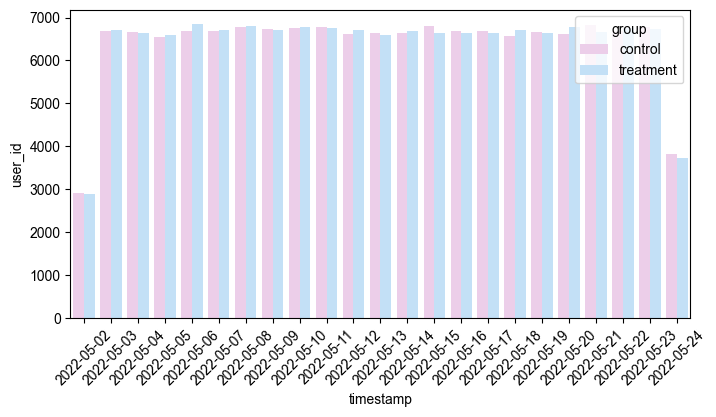

In [13]:
plt.figure(figsize=(8, 4))
sns.barplot(data=result, x='timestamp', y='user_id', hue='group', palette=['#F1C9ED', '#BAE1FF'])
plt.xticks(rotation=45) 

sns.set_style("whitegrid")
plt.show()

In [14]:
pd.crosstab(df['group'], df['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,145274,1928
treatment,1965,145311


Разделение на группы:  
Контрольная группа ('control'): Пользователи, которые будут видеть текущую версию сайта.  
Тестовая группа ('treatment'): Пользователи, которые будут видеть новый дизайн сайта.

Прежде чем продолжим, давайте проверим данные на предмет дубликатов пользователей из нашей выборки. Бывает такое, что пользователь купил сначала в 1 группе, затем во второй 2

In [17]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(f"У нас имеются {duplicate_users} пользователей, которые не уникальны в нашей выборке.")

У нас имеются 0 пользователей, которые не уникальны в нашей выборке.


время провести "эксперимент" и случайным образом достать по 4720 пользователей для каждой группы испытуемых. Существует метод Pandas который называется DataFrame.sample() Он позволяет провести простой случайный отбор.  
Однако стоит обратить внимание на то, что наша контрольная группа пользователей видела и новую версию сайта, а так же тестовая группа пользователей видела старую версию сайта. Я не буду удалять их, а буду "доставать" только тех из контрольной группы, кто видел старую версию и из тестовой, кто видел новую версию сайта. 

In [19]:
control_sample = df[(df['group'] == 'control') & (df['variants'] == 'standard')].sample(n = required_n, random_state=42)
treatment_sample = df[(df['group'] == 'treatment') & (df['variants'] == 'svm_ensemble_v_1_22')].sample(n = required_n, random_state=42)

print(control_sample[control_sample['variants'] == 'svm_ensemble_v_1_22'].value_counts())
print(treatment_sample[treatment_sample['variants'] == 'standard'].value_counts())

# Сформируем общую случайную выборку
ab_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_df.reset_index(drop=True, inplace=True)
ab_df.head()

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,2818e9bf-53e6-49c5-b99c-334f43f212ed,2022-05-10 09:09:40.751637,control,standard,0,United Kingdom,34-41,registered_user
1,1c408718-c9db-4aad-8a3b-f2ecd239eee5,2022-05-13 22:27:34.228088,control,standard,0,United Kingdom,18-25,new_user
2,3f7ead5e-67f3-4992-9d4f-c27b7699527e,2022-05-08 07:36:16.560979,control,standard,0,United Kingdom,42-49,registered_user
3,5bd23952-1f0e-467d-83d1-b9d9230057f3,2022-05-14 15:35:18.212769,control,standard,0,United Kingdom,34-41,registered_user
4,34b99951-b9a9-41cf-adc4-aeb9fe04cc9b,2022-05-20 17:02:53.291693,control,standard,0,United Kingdom,18-25,registered_user


In [20]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    9440 non-null   object        
 1   timestamp  9440 non-null   datetime64[ns]
 2   group      9440 non-null   object        
 3   variants   9440 non-null   object        
 4   converted  9440 non-null   int64         
 5   location   9440 non-null   object        
 6   age_group  9440 non-null   object        
 7   user_type  9440 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 590.1+ KB


убедимся что в наши группы попали пользователи по группам возрастов достаточно равномерно

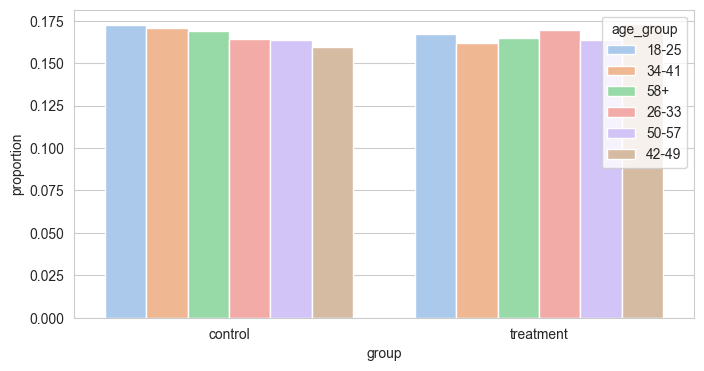

In [22]:
age_distribution = ab_df.groupby(['group'])['age_group'].value_counts(normalize=True).reset_index(name='proportion')

plt.figure(figsize=(8, 4))
palette = sns.color_palette("pastel", n_colors=6)
sns.barplot(data=age_distribution, x='group', y='proportion', hue='age_group', palette=palette)
sns.set_style("whitegrid")

plt.show()

In [23]:
ab_df.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

**3. Визуализация Результатов Эксперимента**

Рассчитаем выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки:

In [25]:
conversion_rates = ab_df.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg(['mean', std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates

,CR mean,CR std,CR se
group,,,
control,0.122458,0.327814,0.004772
treatment,0.124788,0.330479,0.004810


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~12.25% против ~12.47%. 

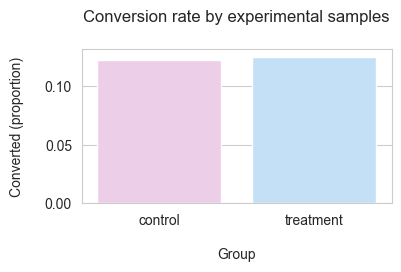

In [27]:
plt.figure(figsize=(4, 2))
sns.barplot(x='group', y='converted', data=ab_df, hue='group', palette=['#F1C9ED', '#BAE1FF'], errorbar=('ci', False));
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

plt.show()


Действительно ли разница между двумя группами испытуемых является статистически значимой? И какой же вариант нам стоит оставить?

**4. Тестирование гипотезы**

Последним шагом в нашем анализе - остается построить инференциальный вывод (инференс, влияние). Так как у нас достаточно большая выборка, мы будем использовать нормальную аппроксимацию (в случае обратной ситуации с малой выборкой - как помним из лекции T-распределение). Мы можем рассчитать p-статистику (Z-test)

In [30]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_df[ab_df['group'] == 'control']['converted']
treatment_results = ab_df[ab_df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'CI 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z-statistic: -0.34
p-value: 0.731
CI 95% for control group: [0.113, 0.132]
CI 95% for treatment group: [0.115, 0.134]


**5. Интерпретация результатов**


Мы получили p-значение = 0.731, что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.  
Доверительный интервал для испытуемой группы [0.115, 0.134] или 11.5% и 13.4% соответственно:
1. Он включает наш baseline
2. Он не достигает нашей цели 15%

Мы можем интерпретировать это как - наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет близок к baseline чем к 15%, который мы определили по нашей цели. Таким образом у нас два выбора:
1. Так как мы будем близко к baseline то в случае если сайт воспринимается "красиво" можно его оставить.
2. Можно создать новую версию (потратить время, деньги, нервы) и опять протестировать, надо решать стоят ли затраты на новую версию 2% улучшения (покроются ли затраты на работу) - задача уже финансов, а может и вас :) Считается коэффициент окупаемости и ROI. Если да - можем попробовать еще раз.
3. Ничего не менять.

## 2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)?

Разобьем нашу выборку на две (для новых/старых пользователей (new/registered user)).

In [35]:
df_new_user = df[df['user_type'] == 'new_user']
df_registered_user = df[df['user_type'] == 'registered_user']

Для каждой выборки по условиям задания мы должны повторить тест и сделать выводы.  
***Для начала посчитаем вывод для типа пользователей 'user_type' = 'new_user'***

In [37]:
pd.crosstab(df_new_user['group'], df_new_user['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,72791,959
treatment,1006,72482


Разделение на группы:  
Контрольная группа ('control'): Пользователи, которые будут видеть текущую версию сайта.  
Тестовая группа ('treatment'): Пользователи, которые будут видеть новый дизайн сайта.

In [39]:
control_sample_new_user = df_new_user[(df_new_user['group'] == 'control') & (df_new_user['variants'] == 'standard')].sample(n = required_n, random_state=42)
treatment_sample_new_user = df_new_user[(df_new_user['group'] == 'treatment') & (df_new_user['variants'] == 'svm_ensemble_v_1_22')].sample(n = required_n, random_state=42)

print(control_sample_new_user[control_sample_new_user['variants'] == 'svm_ensemble_v_1_22'].value_counts())
print(treatment_sample_new_user[treatment_sample_new_user['variants'] == 'standard'].value_counts())

# Сформируем общую случайную выборку
ab_df_new_user = pd.concat([control_sample_new_user, treatment_sample_new_user], axis=0)
ab_df_new_user.reset_index(drop=True, inplace=True)
ab_df_new_user.head()

Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: int64)


,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,d537fe14-23d0-4a71-ad6c-c4502ab3299e,2022-05-23 03:36:33.388524,control,standard,0,United Kingdom,18-25,new_user
1,3dc13667-413c-4729-9904-ba0c72bddb84,2022-05-05 03:31:16.543145,control,standard,0,United Kingdom,26-33,new_user
2,f6818045-16a2-43fb-a891-ade8c98f8466,2022-05-21 01:15:15.711131,control,standard,0,United Kingdom,34-41,new_user
3,fe791ea1-a90a-4bd4-8ce8-17b13420a482,2022-05-03 18:36:20.055898,control,standard,0,United Kingdom,34-41,new_user
4,e4ed1ed8-a9be-4494-a42c-18cc73f5321c,2022-05-02 19:56:20.904862,control,standard,0,United Kingdom,42-49,new_user


убедимся что в наши группы попали пользователи по группам возрастов достаточно равномерно

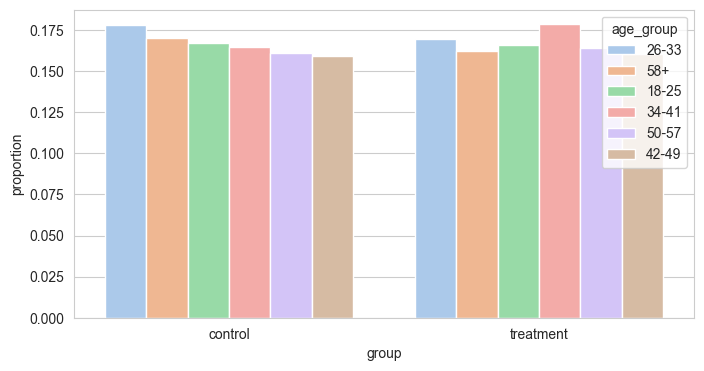

In [41]:
age_distribution_new_user = ab_df_new_user.groupby(['group'])['age_group'].value_counts(normalize=True).reset_index(name='proportion')

plt.figure(figsize=(8, 4))
palette = sns.color_palette("pastel", n_colors=6)
sns.barplot(data=age_distribution_new_user, x='group', y='proportion', hue='age_group', palette=palette)
sns.set_style("whitegrid")

plt.show()

In [42]:
ab_df_new_user.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

Рассчитаем выборочные статистики, чтобы понять каково распределение данных и как выглядят наши выборки:

In [44]:
conversion_rates_new_user = ab_df_new_user.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion_new_user = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion_new_user = lambda x: stats.sem(x, ddof=0)

conversion_rates_new_user = conversion_rates_new_user.agg(['mean', std_proportion_new_user, se_proportion_new_user]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_new_user

,CR mean,CR std,CR se
group,,,
control,0.114195,0.318048,0.004629
treatment,0.118856,0.323619,0.004710


Как мы видим по метрикам, два эксперимента +/- по выборочным статистикам показывают себя одинаково, за исключением выборочного среднего коэффициента конверсии ~11.42% против ~11.89%.

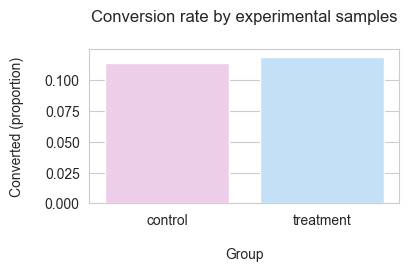

In [46]:
plt.figure(figsize=(4, 2))
sns.barplot(x='group', y='converted', data=ab_df_new_user, hue='group', palette=['#F1C9ED', '#BAE1FF'], errorbar=('ci', False));
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

plt.show()

Последним шагом в нашем анализе - остается построить инференциальный вывод (инференс, влияние). Так как у нас достаточно большая выборка, мы будем использовать нормальную аппроксимацию (в случае обратной ситуации с малой выборкой - как помним из лекции T-распределение). Мы можем рассчитать p-статистику (Z-test)

In [48]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results_new_user = ab_df_new_user[ab_df_new_user['group'] == 'control']['converted']
treatment_results_new_user = ab_df_new_user[ab_df_new_user['group'] == 'treatment']['converted']

n_con_new_user = control_results_new_user.count()
n_treat_new_user = treatment_results_new_user.count()
successes_new_user = [control_results_new_user.sum(), treatment_results_new_user.sum()]
nobs_new_user = [n_con_new_user, n_treat_new_user]

z_stat_new_user, pval_new_user = proportions_ztest(successes_new_user, nobs=nobs)
(lower_con_new_user, lower_treat_new_user), (upper_con_new_user, upper_treat_new_user) = proportion_confint(successes_new_user, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat_new_user:.2f}')
print(f'p-value: {pval_new_user:.3f}')
print(f'CI 95% for control group: [{lower_con_new_user:.3f}, {upper_con_new_user:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat_new_user:.3f}, {upper_treat_new_user:.3f}]')

Z-statistic: -0.71
p-value: 0.480
CI 95% for control group: [0.105, 0.123]
CI 95% for treatment group: [0.110, 0.128]


Мы получили p-значение = 0.48, что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.  
Доверительный интервал для испытуемой группы [0.110, 0.128] или 11.0% и 12.8% соответственно:
1. Он включает наш baseline
2. Он не достигает нашей цели 15%

Мы можем интерпретировать это как - наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет близок к baseline чем к 15%, который мы определили по нашей цели. Таким образом у нас два выбора:
1. Так как мы будем близко к baseline то в случае если сайт воспринимается "красиво" можно его оставить.
2. Можно создать новую версию (потратить время, деньги, нервы) и опять протестировать, надо решать стоят ли затраты на новую версию 2% улучшения (покроются ли затраты на работу) - задача уже финансов, а может и вас :) Считается коэффициент окупаемости и ROI. Если да - можем попробовать еще раз.
3. Ничего не менять.

***Далее посчитаем вывод для типа пользователей 'user_type' = 'registered_user'***

In [51]:
pd.crosstab(df_registered_user['group'], df_registered_user['variants'])

variants,standard,svm_ensemble_v_1_22
group,,
control,72483,969
treatment,959,72829


Разделение на группы:  
Контрольная группа ('control'): Пользователи, которые будут видеть текущую версию сайта.  
Тестовая группа ('treatment'): Пользователи, которые будут видеть новый дизайн сайта.

In [53]:
control_sample_registered_user = df_registered_user[(df_registered_user['group'] == 'control') & (df_registered_user['variants'] == 'standard')].sample(n = required_n, random_state=42)
treatment_sample_registered_user = df_registered_user[(df_registered_user['group'] == 'treatment') & (df_registered_user['variants'] == 'svm_ensemble_v_1_22')].sample(n = required_n, random_state=42)

# Сформируем общую случайную выборку
ab_df_registered_user = pd.concat([control_sample_registered_user, treatment_sample_registered_user], axis=0)
ab_df_registered_user.reset_index(drop=True, inplace=True)

In [54]:
ab_df_registered_user.group.value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

In [55]:
conversion_rates_registered_user = ab_df_registered_user.groupby('group')['converted']

# Стандартное отклонение для сформированной выборки
std_proportion_registered_user = lambda x: np.std(x, ddof=0)
# Стандартная ошибка для сформированной выборки, формулу стандартной ошибки вы знаете из лекций. Забыли - погуглите.
se_proportion_registered_user = lambda x: stats.sem(x, ddof=0)

conversion_rates_registered_user = conversion_rates_registered_user.agg(['mean', std_proportion_registered_user, se_proportion_registered_user]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
conversion_rates_registered_user

,CR mean,CR std,CR se
group,,,
control,0.123729,0.329272,0.004793
treatment,0.120763,0.325851,0.004743


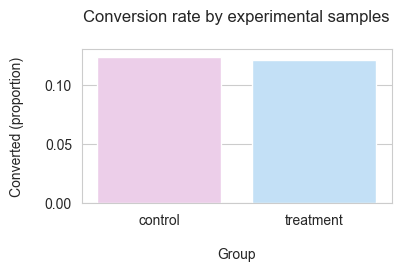

In [56]:
plt.figure(figsize=(4, 2))
sns.barplot(x='group', y='converted', data=ab_df_registered_user, hue='group', palette=['#F1C9ED', '#BAE1FF'], errorbar=('ci', False));
plt.title('Conversion rate by experimental samples', pad=20)
plt.xlabel('Group', labelpad=15);
plt.ylabel('Converted (proportion)', labelpad=15);

plt.show()

In [57]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results_registered_user = ab_df_registered_user[ab_df_registered_user['group'] == 'control']['converted']
treatment_results_registered_user = ab_df_registered_user[ab_df_registered_user['group'] == 'treatment']['converted']

n_con_registered_user = control_results_registered_user.count()
n_treat_registered_user = treatment_results_registered_user.count()
successes_registered_user = [control_results_registered_user.sum(), treatment_results_registered_user.sum()]
nobs = [n_con_registered_user, n_treat_registered_user]

z_stat_registered_user, pval_registered_user = proportions_ztest(successes_registered_user, nobs=nobs)
(lower_con_registered_user, lower_treat_registered_user), (upper_con_registered_user, upper_treat_registered_user) = proportion_confint(successes_registered_user, nobs=nobs, alpha=0.05)

print(f'Z-statistic: {z_stat_registered_user:.2f}')
print(f'p-value: {pval_registered_user:.3f}')
print(f'CI 95% for control group: [{lower_con_registered_user:.3f}, {upper_con_registered_user:.3f}]')
print(f'CI 95% for treatment group: [{lower_treat_registered_user:.3f}, {upper_treat_registered_user:.3f}]')

Z-statistic: 0.44
p-value: 0.660
CI 95% for control group: [0.114, 0.133]
CI 95% for treatment group: [0.111, 0.130]


Мы получили p-значение = 0.66, что является высоким показателем по сравнению с выбранной альфой 0.05, то согласно статистическому выводу, мы не можем отклонить нулевую гипотезу H0, что означает наш сайт никак статистически значимо не влияет на уровень конверсии и повышение уровня конверсии - это случайность.  
Доверительный интервал для испытуемой группы [0.111, 0.130] или 11.1% и 13.0% соответственно:
1. Он включает наш baseline
2. Он не достигает нашей цели 15%

Мы можем интерпретировать это как - наиболее вероятно, что реальный уровень конверсии сайта с новым дизайном будет близок к baseline чем к 15%, который мы определили по нашей цели. Таким образом у нас два выбора:
1. Так как мы будем близко к baseline то в случае если сайт воспринимается "красиво" можно его оставить.
2. Можно создать новую версию (потратить время, деньги, нервы) и опять протестировать, надо решать стоят ли затраты на новую версию 2% улучшения (покроются ли затраты на работу) - задача уже финансов, а может и вас :) Считается коэффициент окупаемости и ROI. Если да - можем попробовать еще раз.
3. Ничего не менять.